In [19]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import sscCdi
import scipy

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft

%matplotlib widget

In [134]:
def alignment_variance_field(data,upsampling_factor=10):
    
    neighbor_shifts = np.empty((data.shape[0],2))
    
    print('Finding shift between neighboor slices...')
    for i in range(0,data.shape[0]-1):

        local_variance1 = calculate_local_variance_field(data[i])
        local_variance2 = calculate_local_variance_field(data[i+1])
        
        shift, error, diffphase = phase_cross_correlation(local_variance1, local_variance2, upsample_factor=upsampling_factor)

        neighbor_shifts[i][0] = shift[0]
        neighbor_shifts[i][1] = shift[1]
        
    total_shift = np.cumsum(neighbor_shifts,axis=0)
    aligned_volume = np.zeros_like(data)
    aligned_volume[0] = data[0]
    
    print('Shifting slices...')
    for i in range(0,data.shape[0]-1):
        aligned_volume[i+1] = scipy.ndimage.shift(data[i+1],total_shift[i])
    
    print('Finding common useful region for whole volume...')
    masked_volume = np.where(aligned_volume==0,0,1)
    product = np.prod(np.abs(masked_volume),axis=0)
    where_null = np.where(np.abs(product) == 0,0,1)
    
    # plt.figure()
    # plt.imshow(np.abs(aligned_volume[-1]))
    
    aligned_volume[:] = np.where(where_null==1,aligned_volume,0) 

    print('Done')
    return aligned_volume, neighbor_shifts

def shift_2d_replace(data, dx, dy, constant=False):
    """
    Shifts the array in two dimensions while setting rolled values to constant
    :param data: The 2d numpy array to be shifted
    :param dx: The shift in x
    :param dy: The shift in y
    :param constant: The constant to replace rolled values with
    :return: The shifted array with "constant" where roll occurs
    """
    shifted_data = np.roll(data, dx, axis=1)
    if dx < 0:
        shifted_data[:, dx:] = constant
    elif dx > 0:
        shifted_data[:, 0:dx] = constant

    shifted_data = np.roll(shifted_data, dy, axis=0)
    if dy < 0:
        shifted_data[dy:, :] = constant
    elif dy > 0:
        shifted_data[0:dy, :] = constant
    return shifted_data


def get_gaussian_pyramid(frame,layers=2):

    from skimage.transform import pyramid_gaussian

    img_real = np.real(frame)
    img_imag = np.imag(frame)

    pyramid_real = tuple(pyramid_gaussian(img_real,downscale=2,max_layer=layers-1))
    pyramid_imag = tuple(pyramid_gaussian(img_imag,downscale=2,max_layer=layers-1))
    
    pyramid = []
    for R, I in zip(pyramid_real,pyramid_imag):
        pyramid.append(R+1j*I)

    return pyramid

def calculate_local_variance_field(matrix):
    
    gradient = np.gradient(matrix)
    del_x = gradient[1]
    del_y = gradient[0]
        
    return np.sqrt(np.abs(del_x)**2 + np.abs(del_y)**2)

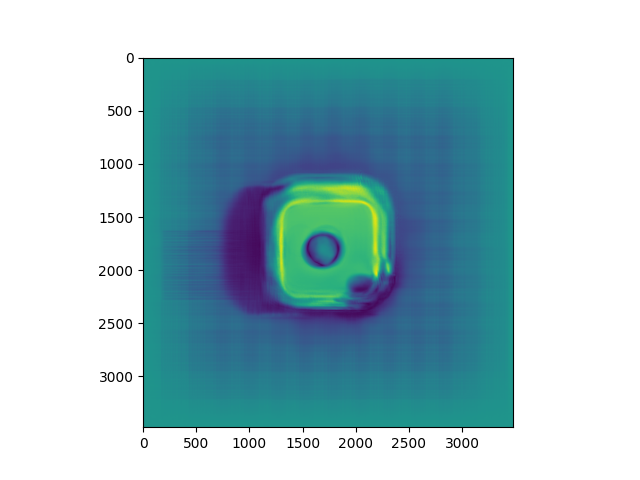

In [138]:
# path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/temp/2023-05-16-15h38m_glass_sphere_phase_cropped_sinogram.npy"
# data = np.load(path)[0:10]

path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/2023-05-16-15h38m_glass_sphere.hdf5"
data = h5py.File(path,'r')['recon/object'][()]

mean = np.mean(data,axis=0)

plt.figure()
plt.imshow(np.abs(mean))

data=data[:,1350:-1400,1400:-1400]

In [ ]:
aligned_volume, neighbor_shifts = alignment_variance_field(data)

Finding shift between neighboor slices...
0 [-50.1 -20.2]
10 [  8.6 -26.2]
20 [ 12.  -23.3]
30 [21.  -8.7]
40 [13.6 -4.5]
50 [13.  15.3]
60 [-0.4 11.9]
70 [  7.9 -14.1]
80 [-5.2 -5.3]
90 [ 0.7 -9.8]
100 [-28.8  22. ]


In [ ]:
sscCdi.misc.deploy_visualizer(np.abs(data),title='sample',cmap='gray')

In [ ]:
sscCdi.misc.deploy_visualizer(np.abs(aligned_volume),title='sample',cmap='gray')

In [10]:
# sscCdi.misc.deploy_visualizer(data,title='sample',cmap='gray')